# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import project_tests as t

import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
df = df.drop(columns = ['Unnamed: 0'])
df_content = df_content.drop(columns = ['Unnamed: 0'])

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

--- User-Item Interactions Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45993 non-null  float64
 1   title       45993 non-null  object 
 2   email       45976 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB

--- Articles Community Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB

--- User-Item Interactions Dataset Head ---
   article_id                    

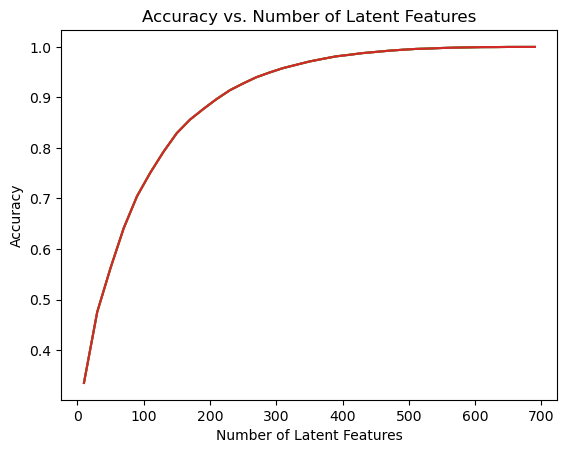

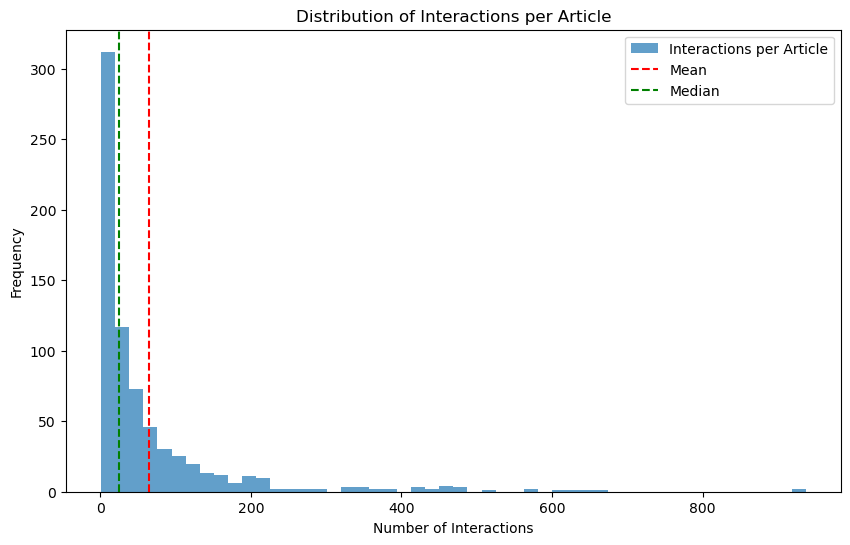


--- Top 20 Articles by Interactions ---
title
use deep learning for image classification                            937
insights from new york car accident reports                           927
visualize car data with brunel                                        671
use xgboost, scikit-learn & ibm watson machine learning apis          643
predicting churn with the spss random tree algorithm                  627
healthcare python streaming application demo                          614
finding optimal locations of new store using decision optimization    572
apache spark lab, part 1: basic concepts                              565
analyze energy consumption in buildings                               512
gosales transactions for logistic regression model                    483
welcome to pixiedust                                                  481
customer demographics and sales                                       473
total population by country                                      

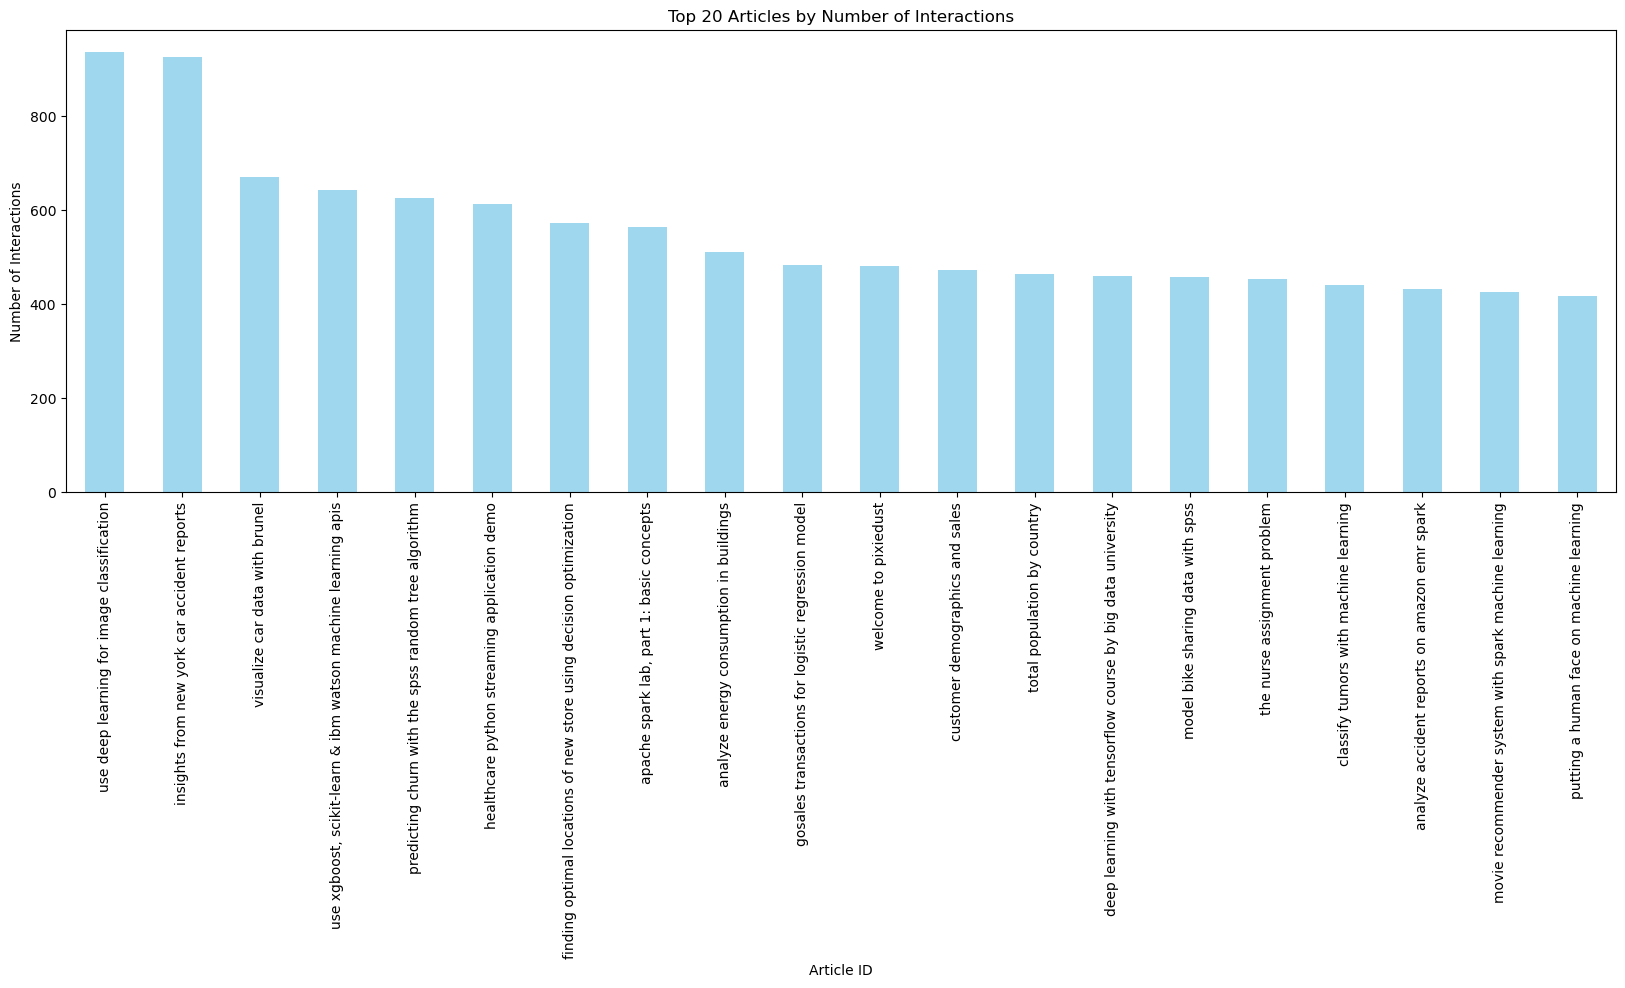


--- Missing Value Percentages ---
doc_body           1.325758
doc_description    0.284091
doc_full_name      0.000000
doc_status         0.000000
article_id         0.000000
dtype: float64


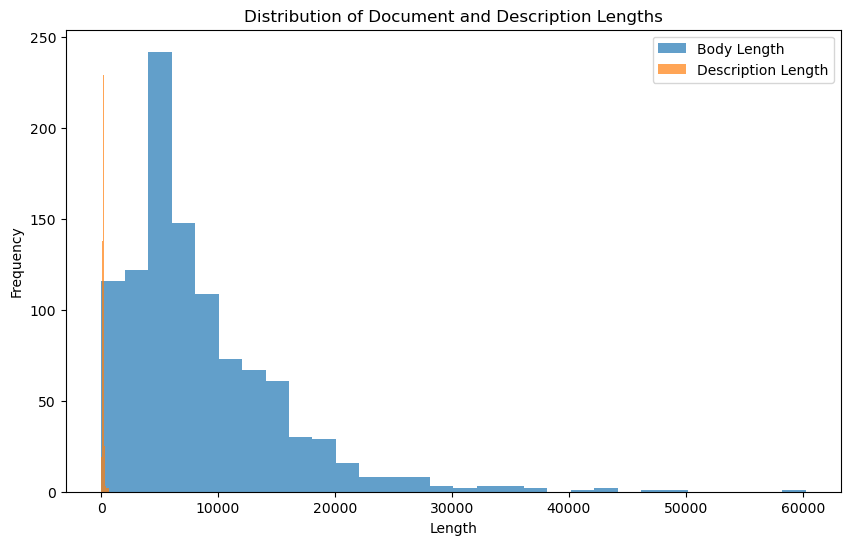


--- Most Common Words in doc_body ---
[('data', 18401), ('use', 4508), ('new', 4203), ('ibm', 3772), ('using', 3724), ('learning', 3232), ('database', 3159), ('1', 2905), ('get', 2809), ('science', 2724), ('one', 2540), ('compose', 2510), ('create', 2412), ('like', 2351), ('analytics', 2264), ('share', 2214), ('code', 2088), ('machine', 2067), ('cloudant', 2067), ('need', 2060)]

--- Document Status Distribution ---
doc_status
Live    1056
Name: count, dtype: int64


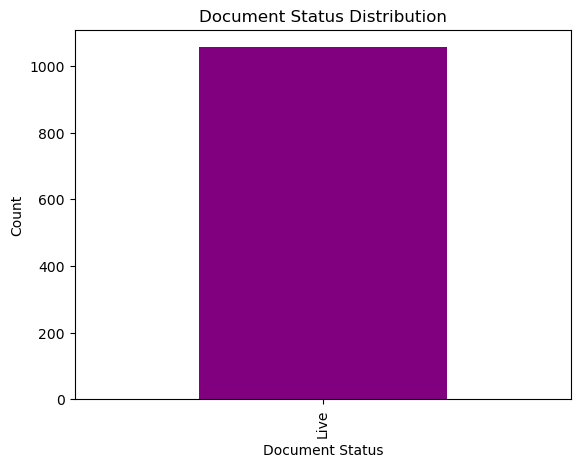


Duplicate Article IDs: 5

--- Top 20 TF-IDF Features ---
['analytics' 'cloudant' 'code' 'compose' 'create' 'data' 'database' 'ibm'
 'learning' 'like' 'll' 'machine' 'model' 'new' 'science' 'share' 'spark'
 'time' 'use' 'using']


In [270]:
# Display basic info about the datasets
print("--- User-Item Interactions Dataset Info ---")
df.info()
print("\n--- Articles Community Dataset Info ---")
df_content.info()

# Preview the datasets
print("\n--- User-Item Interactions Dataset Head ---")
print(df.head())
print("\n--- Articles Community Dataset Head ---")
print(df_content.head())

# Check for missing values
print("\n--- Missing Values ---")
print("User-Item Interactions Missing Values:\n", df.isnull().sum())
print("Articles Community Missing Values:\n", df_content.isnull().sum())

# Descriptive statistics
print("\n--- Descriptive Statistics for User-Item Interactions ---")
print(df.describe(include='all'))
print("\n--- Descriptive Statistics for Articles Community ---")
print(df_content.describe(include='all'))

# Unique user and article counts
print("\n--- Unique Counts ---")
print(f"Unique Articles: {df['article_id'].nunique()}")
print(f"Unique Articles in Content: {df_content['article_id'].nunique()}")

# Interaction statistics
interactions_per_article = df.groupby('title')['email'].count()
interactions_per_user = df.groupby('email')['article_id'].count()

print("\n--- Interaction Statistics ---")
print(f"Average Interactions per Article: {interactions_per_article.mean():.2f}")
print(f"Median Interactions per Article: {interactions_per_article.median():.2f}")

# Fill in the median and maximum number of user_article interactions
median_val = interactions_per_user.median()  # 50% of individuals interact with this number of articles or fewer.
max_views_by_user = interactions_per_user.max()  # The maximum number of user-article interactions by any 1 user.

print(f"Median number of user-article interactions: {median_val}")
print(f"Maximum number of user-article interactions: {max_views_by_user}")

# Visualizations
plt.figure(figsize=(10, 6))
plt.hist(interactions_per_article, bins=50, alpha=0.7, label='Interactions per Article')
plt.axvline(interactions_per_article.mean(), color='r', linestyle='--', label='Mean')
plt.axvline(interactions_per_article.median(), color='g', linestyle='--', label='Median')
plt.title('Distribution of Interactions per Article')
plt.xlabel('Number of Interactions')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Articles with the most interactions
top_articles = interactions_per_article.sort_values(ascending=False).head(20)
print("\n--- Top 20 Articles by Interactions ---")
print(top_articles)

plt.figure(figsize=(20, 6))
top_articles.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Top 20 Articles by Number of Interactions')
plt.xlabel('Article ID')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=90)
plt.show()

# Explore missing values in df_content
missing_values = df_content.isnull().mean() * 100
print("\n--- Missing Value Percentages ---")
print(missing_values)

# Add text length analysis
df_content['body_length'] = df_content['doc_body'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
df_content['description_length'] = df_content['doc_description'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

plt.figure(figsize=(10, 6))
plt.hist(df_content['body_length'], bins=30, alpha=0.7, label='Body Length')
plt.hist(df_content['description_length'], bins=30, alpha=0.7, label='Description Length')
plt.legend()
plt.title('Distribution of Document and Description Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

# Word frequency analysis
stop_words = set(stopwords.words('english'))
all_words = ' '.join(df_content['doc_body'].dropna())
filtered_words = [word for word in word_tokenize(all_words.lower()) if word.isalnum() and word not in stop_words]
word_counts = Counter(filtered_words).most_common(20)
print("\n--- Most Common Words in doc_body ---")
print(word_counts)

# Document status distribution
status_counts = df_content['doc_status'].value_counts()
print("\n--- Document Status Distribution ---")
print(status_counts)

status_counts.plot(kind='bar', title='Document Status Distribution', color='purple')
plt.xlabel('Document Status')
plt.ylabel('Count')
plt.show()

# Validate uniqueness of article_id
duplicates = df_content['article_id'].duplicated().sum()
print(f"\nDuplicate Article IDs: {duplicates}")

# TF-IDF Analysis
vectorizer = TfidfVectorizer(max_features=20, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_content['doc_body'].dropna())
print("\n--- Top 20 TF-IDF Features ---")
print(vectorizer.get_feature_names_out())

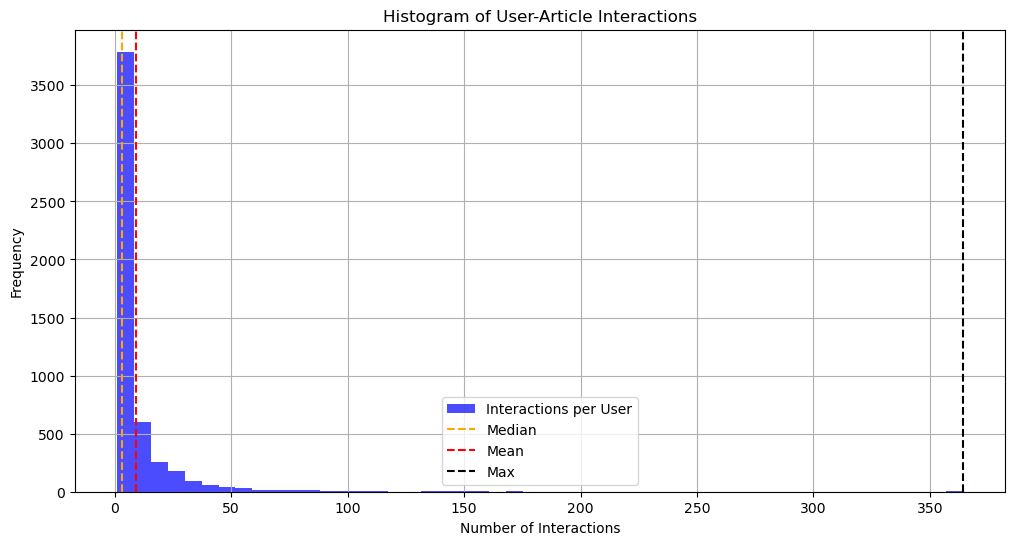

In [271]:
# Calculate interactions per user and per article
interactions_per_user = df.groupby('email')['article_id'].count()
interactions_per_article = df.groupby('article_id')['email'].count()

# Plot histogram of interactions per user
plt.figure(figsize=(12, 6))
plt.hist(interactions_per_user, bins=50, alpha=0.7, color='blue', label='Interactions per User')
plt.axvline(interactions_per_user.median(), color='orange', linestyle='--', label='Median')
plt.axvline(interactions_per_user.mean(), color='red', linestyle='--', label='Mean')
plt.axvline(interactions_per_user.max(), color='black', linestyle='--', label='Max')

plt.title('Histogram of User-Article Interactions')
plt.xlabel('Number of Interactions')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [272]:
# Fill in the median and maximum number of user_article interactios below
interactions_per_user = df.groupby('email')['article_id'].count()

# Fill in the median and maximum number of user_article interactions
median_val = interactions_per_user.median()  # 50% of individuals interact with this number of articles or fewer.
max_views_by_user = interactions_per_user.max()  # The maximum number of user-article interactions by any 1 user.

print(f"Median number of user-article interactions: {median_val}")
print(f"Maximum number of user-article interactions: {max_views_by_user}")

# Interaction statistics
interactions_per_article = df.groupby('article_id')['email'].count()

print("\n--- Interaction Statistics ---")
print(f"Average Interactions per Article: {interactions_per_article.mean():.2f}")
print(f"Median Interactions per Article: {interactions_per_article.median():.2f}")

Median number of user-article interactions: 3.0
Maximum number of user-article interactions: 364

--- Interaction Statistics ---
Average Interactions per Article: 64.39
Median Interactions per Article: 25.00


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [273]:
# Find and explore duplicate articles
df_content['doc_full_name'].value_counts().head(10)

doc_full_name
How smart catalogs can turn the big data flood into an ocean of opportunity                     2
Self-service data preparation with IBM Data Refinery                                            2
Graph-based machine learning                                                                    2
Using Apache Spark as a parallel processing framework for accessing REST based data services    2
Use the Primary Index                                                                           2
Detect Malfunctioning IoT Sensors with Streaming Analytics                                      1
Word2Vec in Data Products                                                                       1
Use Aginity Workbench for IBM dashDB                                                            1
Building CouchApps                                                                              1
Access an On-Premises DB2 Data Server from the Bluemix Cloud                                    1
Name: 

In [274]:
df_content[df_content['article_id'].isin(df_content['article_id'].value_counts()[df_content['article_id'].value_counts() == 2].index)].sort_values('article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id,body_length,description_length
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50,9903,28
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50,10869,197
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221,11574,124
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221,8403,194
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232,4912,193
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232,4883,193
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398,10008,200
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398,9868,200
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577,271,97
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577,167,89


#### Found duplicate articles which do not completly match in the content. The duplicates are not exact duplicates, but rather have different doc_full_name values. This could be due to different versions of the same article.We will drop the duplicates based on the article_id and keep the first version of the article in respect to body length.

In [275]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates('article_id', keep = 'first')

In [276]:
# Check if there are any duplicates left
df_content[df_content['article_id'].isin(df_content['article_id'].value_counts()[df_content['article_id'].value_counts() == 2].index)].sort_values('article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id,body_length,description_length


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [277]:
# a. The number of unique articles that have an interaction with a user
unique_articles = df['article_id'].nunique()
print(f"The number of unique articles with at least one interaction: {unique_articles}")

# b. The number of unique articles in the dataset (whether they have any interactions or not)
total_articles = df_content['article_id'].nunique()
print(f"The number of unique articles on the IBM platform: {total_articles}")

# c. The number of unique users in the dataset (excluding null values)
unique_users = df['email'].nunique()
print(f"The number of unique users: {unique_users}")

# d. The number of user-article interactions in the dataset
user_article_interactions = df.shape[0]
print(f"The number of user-article interactions: {user_article_interactions}")

The number of unique articles with at least one interaction: 714
The number of unique articles on the IBM platform: 1051
The number of unique users: 5148
The number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [278]:
# Find the most viewed article_id and its number of views
most_viewed_article_id = str(df['article_id'].value_counts().idxmax())  # Convert to string with one value following the decimal
max_views = df['article_id'].value_counts().max()  # Maximum number of views for the most viewed article

print(f"The most viewed article in the dataset: {most_viewed_article_id}")
print(f"The most viewed article was viewed {max_views} times.")

The most viewed article in the dataset: 1429.0
The most viewed article was viewed 937 times.


In [279]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [280]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [281]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    interactions_per_article = df.groupby('title')['user_id'].count()
    top_articles = interactions_per_article.sort_values(ascending=False).head(n)
    
    
    return top_articles.index.to_list() # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    interactions_per_article = df.groupby('article_id')['user_id'].count()
    top_articles = interactions_per_article.sort_values(ascending=False).head(n) 
    return top_articles.index.astype(str).to_list() # Return the top article ids as strings

In [282]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [283]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [284]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Group by user_id and article_id to mark interactions
    user_item = df.groupby(['user_id', 'article_id']).size().unstack(fill_value=0)
    
    # Convert to binary: any interaction gets a 1
    user_item = user_item.applymap(lambda x: 1 if x > 0 else 0)
    
    return user_item # return the user_item matrix 

# Example usage
user_item = create_user_item_matrix(df)

/var/folders/jv/wftllc_j4sx4jnc7gv613nq00000gn/T/ipykernel_21468/2774604313.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  user_item = user_item.applymap(lambda x: 1 if x > 0 else 0)


In [285]:
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [286]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [287]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of user ids based on similarity, excluding the provided user_id.
    '''
    # Compute the similarity of each user to the provided user
    user_vector = user_item.loc[user_id]  # Retrieve the user vector for the given user_id
    similarity = user_item.dot(user_vector)  # Compute dot product for similarity
    
    # Sort by similarity in descending order
    similarity = similarity.sort_values(ascending=False)
    
    # Create a list of just the ids
    most_similar_users = similarity.index.tolist()
    
    # Remove the own user's id from the list
    most_similar_users.remove(user_id)
    
    return most_similar_users  # return a list of users in order from most to least similar

In [288]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [289]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Use DataFrame filtering to map IDs to names
    article_names = df[df['article_id'].astype(str).isin(article_ids)]['title'].drop_duplicates().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Get the articles the user has interacted with (article IDs)
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype(str).tolist()
    # Get article names using get_article_names
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    '''
    # Find similar users
    similar_users = find_similar_users(user_id)
    
    # Get articles already seen by the user
    seen_article_ids, _ = get_user_articles(user_id, user_item)
    
    # Collect recommendations
    recs = set()
    for other_user in similar_users:
        # Get articles seen by the similar user
        other_user_article_ids, _ = get_user_articles(other_user, user_item)
        
        # Add unseen articles to recommendations
        recs.update(set(other_user_article_ids) - set(seen_article_ids))
        
        # Stop if enough recommendations are collected
        if len(recs) >= m:
            break
    
    # Return the first m recommendations
    return list(recs)[:m]  

In [290]:
get_user_articles(user_id = 2, user_item=user_item)

(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'],
 ['healthcare python streaming application demo',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'gosales transactions for naive bayes model',
  'use r dataframes & ibm watson natural language understanding',
  'build a python app on the streaming analytics service',
  'using deep learning to reconstruct high-resolution audio'])

In [291]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['deploy your python model as a restful api',
 'the nurse assignment problem',
 'analyze open data sets with pandas dataframes',
 '502    forgetting the past to learn the future: long ...\nName: title, dtype: object',
 'how smart catalogs can turn the big data flood into an ocean of opportunity',
 'deep learning with data science experience',
 'improving real-time object detection with yolo',
 'easy json loading and social sharing in dsx notebooks',
 'brunel 2.0 preview',
 'automating web analytics through python']

In [292]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [293]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a user has interacted with an article
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Compute the similarity of each user to the given user
    user_vector = user_item.loc[user_id]
    similarity = user_item.dot(user_vector)
    
    # Create a DataFrame with similarity and neighbor_id
    similarity_df = similarity.reset_index().rename(columns={0: 'similarity', 'user_id': 'neighbor_id'})
    
    # Add the number of interactions for each neighbor
    interactions = df.groupby('user_id').size()
    interactions_df = interactions.reset_index().rename(columns={0: 'num_interactions'})
    
    # Merge similarity and interactions data
    neighbors_df = similarity_df.merge(interactions_df, left_on='neighbor_id', right_on='user_id')
    neighbors_df = neighbors_df.drop(columns=['user_id'])
    
    # Remove the input user from the neighbors list
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    # Sort by similarity and number of interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[False, False])
    
    return neighbors_df  # Return the DataFrame specified in the docstring

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Get top sorted users
    neighbors_df = get_top_sorted_users(user_id)
    
    # Get articles seen by the input user
    seen_article_ids, _ = get_user_articles(user_id)
    
    # Store recommendations
    recs = []
    rec_names = []
    
    # Loop through sorted neighbors
    for neighbor_id in neighbors_df['neighbor_id']:
        # Get articles seen by the neighbor
        neighbor_article_ids, _ = get_user_articles(neighbor_id)
        
        # Identify new articles for the input user
        new_recs = list(set(neighbor_article_ids) - set(seen_article_ids))
        
        # Sort new recommendations by total interactions
        article_interactions = df.groupby('article_id').size()
        new_recs = sorted(new_recs, key=lambda x: article_interactions.get(x, 0), reverse=True)
        
        # Add to recommendations
        for article_id in new_recs:
            if article_id not in recs:
                recs.append(article_id)
                rec_names.append(df[df['article_id'] == float(article_id)]['title'].iloc[0])
            
            # Stop if enough recommendations are collected
            if len(recs) >= m:
                break
        
        if len(recs) >= m:
            break

    return recs[:m], rec_names[:m]

In [294]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['109.0', '1276.0', '1411.0', '793.0', '1157.0', '1304.0', '555.0', '1150.0', '651.0', '1278.0']

The top 10 recommendations for user 20 are the following article names:
['tensorflow quick tips', 'deploy your python model as a restful api', 'uci: white wine quality', '10 powerful features on watson data platform, no coding necessary', 'airbnb data for analytics: washington d.c. listings', 'gosales transactions for logistic regression model', 'build a naive-bayes model with wml & dsx', 'airbnb data for analytics: venice calendar', 'analyzing streaming data from kafka topics', 'develop a scala spark model on chicago building violations']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [295]:
### Tests with a dictionary of results

user1_most_sim = find_similar_users(1)[0]# Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[10]# Find the 10th most similar user to user 131

In [296]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

### Recommendations for New Users

When a new user is introduced, they have no interaction history. This creates a **cold-start problem**, where functions relying on user similarity (like `user_user_recs` or `user_user_recs_part2`) cannot be applied, as no similarity can be calculated without prior data. Below is an explanation of the approach to handle this:

---

#### **Functions Usable for Recommendations**
- **Popularity-Based Recommendations**:  
  For new users, the best approach is to recommend the most popular articles globally, as we have no personalized information about their preferences. This can be implemented by identifying articles with the highest number of interactions in the dataset.
  ```python
  get_top_articles(10)

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [297]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs =   get_top_article_ids(10)# Your recommendations here

In [298]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [299]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [300]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [301]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [302]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [303]:
# Perform SVD on the user-item matrix
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True, compute_uv=True)

In our case, the user-item matrix is complete, which allows us to use standard SVD. In contrast, the lesson required the use of FunkSVD because the user-item matrix there was sparse. When the user-item matrix contains empty cells (NaN), traditional SVD cannot be applied. FunkSVD is a suitable alternative for handling such sparse matrices.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

/Users/marco.gruener/anaconda3/envs/Data_science/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


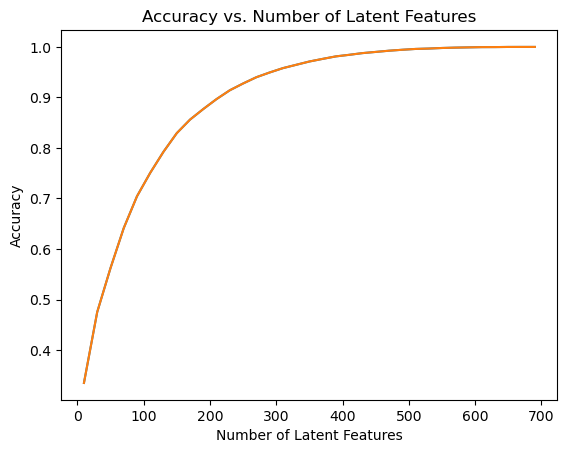

In [310]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.show()

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [313]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index
    test_arts = user_item_test.columns

    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

/var/folders/jv/wftllc_j4sx4jnc7gv613nq00000gn/T/ipykernel_21468/2774604313.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  user_item = user_item.applymap(lambda x: 1 if x > 0 else 0)
/var/folders/jv/wftllc_j4sx4jnc7gv613nq00000gn/T/ipykernel_21468/2774604313.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  user_item = user_item.applymap(lambda x: 1 if x > 0 else 0)


In [322]:
df_test

,article_id,title,user_id
40000,1053.0,access mysql with python,4487
40001,1314.0,healthcare python streaming application demo,4487
40002,1424.0,use spark for python to load data and run sql ...,4487
40003,1176.0,build a python app on the streaming analytics ...,4487
40004,58.0,advancements in the spark community,4488
...,...,...,...
45988,1324.0,ibm watson facebook posts for 2015,5146
45989,142.0,neural networks for beginners: popular types a...,5146
45990,233.0,bayesian nonparametric models – stats and bots,5147
45991,1160.0,analyze accident reports on amazon emr spark,5148


In [325]:
user_in_train_and_test = user_item_test.index.isin(user_item_train.index).sum()
print(f"Users in both train and test set: {user_in_train_and_test}")

Users in both train and test set: 20


In [326]:
users_only_in_test = len(df_test.user_id.unique()) - user_in_train_and_test
print(f"Users only in test set: {users_only_in_test}")

Users only in test set: 662


In [329]:
artikel_in_test = len(df_test.article_id.unique())
print(f"Unique Articles in test set: {artikel_in_test}")

Unique Articles in test set: 574


In [330]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [340]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=True, compute_uv=True)# fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape


((4487, 4487), (714,), (714, 714))

In [372]:
# getting test indices for rows (users) and columns (articles)
test_users_index = user_item_train[user_item_train.index.isin(test_idx)].index
test_articles_index = np.array(user_item_train.loc[:, user_item_train.columns.isin(test_arts)].columns)
test_set = user_item_test.loc[test_users_index, test_articles_index]

In [378]:
# getting test subset of u and vt matrices
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.get_level_values(0).isin(test_arts)]

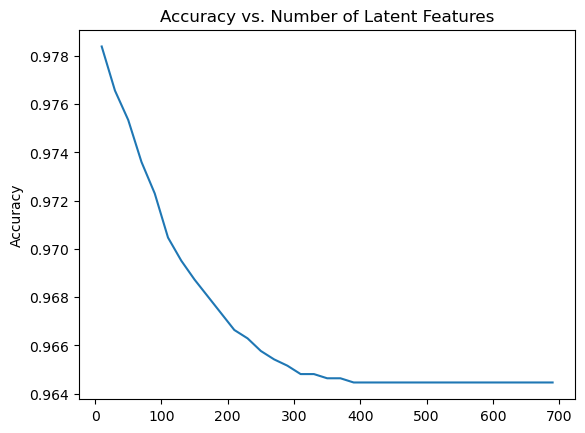

In [381]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

# getting test subset of u and vt matrices
u_test = u_train[test_users_index, :]
vt_test = vt_train[:, test_articles_index]

for k in num_latent_feats:
    # restructure with k latent features
    s_test_new, u_test_new, vt_test_new = np.diag(s_train[:k]), u_test[:, :k], vt_test[:k, :]

    # Recompose the approximate user-item matrix using dot products
    test_pred = np.around(np.dot(np.dot(u_test_new, s_test_new), vt_test_new))

    # compute error for each prediction to actual value
    diffs = np.subtract(test_pred, test_set)

    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs) / test_set.size)
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

The results indicate high accuracy even with as few as 10 latent features. However, the primary limitation of this method is its reliance on a binary user-item matrix, where interactions are represented as 0 (no interaction) or 1 (interaction). This binary representation does not account for user ratings, which could provide valuable insights into how much a user benefited from or enjoyed a specific article. Incorporating user ratings, number of interactions and duration per article into the recommendation system could improve both accuracy and user satisfaction.

The decline in test accuracy as the number of latent features increases is likely due to factors such as overfitting, increased model complexity, and the bias-variance trade-off. Adding more latent features makes the model more complex, allowing it to fit the training data more precisely. However, this precision often comes at the expense of generalization, causing the model to perform poorly on new, unseen data.

In essence, models with more latent features tend to have lower bias but higher variance, making them more susceptible to overfitting and less robust for general recommendations.

For Checking whether the new recommendation systems are an improvement to how users currently find articles we could use A/B testing as a powerful method to determine whether the new recommendation system provides better results than the current one.
Here's how it works:

#### **1. Group Division**
- Split the users into two groups:
  - **Control Group**: Users who continue to receive recommendations through the current system.
  - **Test Group**: Users who receive recommendations from the newly implemented system.

#### **2. Metrics to Measure**
- **Click-Through Rate (CTR)**: The percentage of recommended articles that users click on.
- **Engagement**: Time spent reading or interacting with the recommended articles.
- **Conversion Rate**: Actions taken after interacting with the recommended articles (e.g., purchases, subscriptions).

#### **3. Experiment Setup**
- Ensure that both groups are randomly assigned to avoid biases.
- Monitor the performance of both systems over a defined period.
- Use statistically significant sample sizes to draw meaningful conclusions.

#### **4. Comparison and Analysis**
- Compare the performance metrics between the control and test groups.
- Analyze whether the new system shows a significant improvement in user engagement, CTR, or other business goals.

#### **5. Decision Making**
- If the test group consistently outperforms the control group across key metrics, the new recommendation system can be rolled out more broadly.
- If the performance is similar or worse, refine the new system and repeat the test.

A/B testing provides a structured and reliable way to measure the effectiveness of the new recommendations and ensures decisions are backed by data.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [377]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

/Users/marco.gruener/anaconda3/envs/Data_science/bin/python: No module named nbconvert


1